# What to do before running the script

## Directory structure
+ `data/`
  - `dfits_20171115052750.fits`
+ `pipelines/`
  - `utils/`
    * `__init__.py`
    * `functions.py`: user-defined functions
+ `results/`
+ `snippets/` (**current directory**)
  - `analysis_for_daisy.ipynb`: this file
+ `yaml/`
  - `pointing_params.yaml`: parameters

## Parameter setting
+ `yaml/pointing_params.yaml`
  - modify `file.output_dir` as you like

# Main

In [1]:
# standard libraries
import sys
sys.path.append("../pipelines")
import pathlib

# dependent packages
import yaml
import decode as dc
import pandas as pd
import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import aplpy

# user-defined packages
from utils.functions import makecontinuum
from utils.functions import resample_with_equal_dt
from utils.functions import detrend
from utils.functions import plot_filter_response

# style settings
plt.style.use("seaborn-dark")
plt.style.use("seaborn-muted")

In [2]:
# load DFITS and params
dfits_file = pathlib.Path("../data/dfits_20171115052750.fits") # Uranus
yaml_file = pathlib.Path("../yaml/pointing_params.yaml")
with open(yaml_file) as file:
    params = yaml.load(file, Loader=yaml.SafeLoader)

output_dir = pathlib.Path(params["file"]["output_dir"]).expanduser()
output_dir = pathlib.Path("../results").expanduser()

dpi = params["file"]["dpi"]
ch = params["loaddfits"]["ch"]

cube_fits = output_dir / "cube.fits"
cont_fits = output_dir / "cont.fits"

array = dc.io.loaddfits(dfits_file, **params["loaddfits"])
scanarray = array[array.scantype=="SCAN"]

Endtime of readout is adjusted to that of ANTENNA HDU.


/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The e

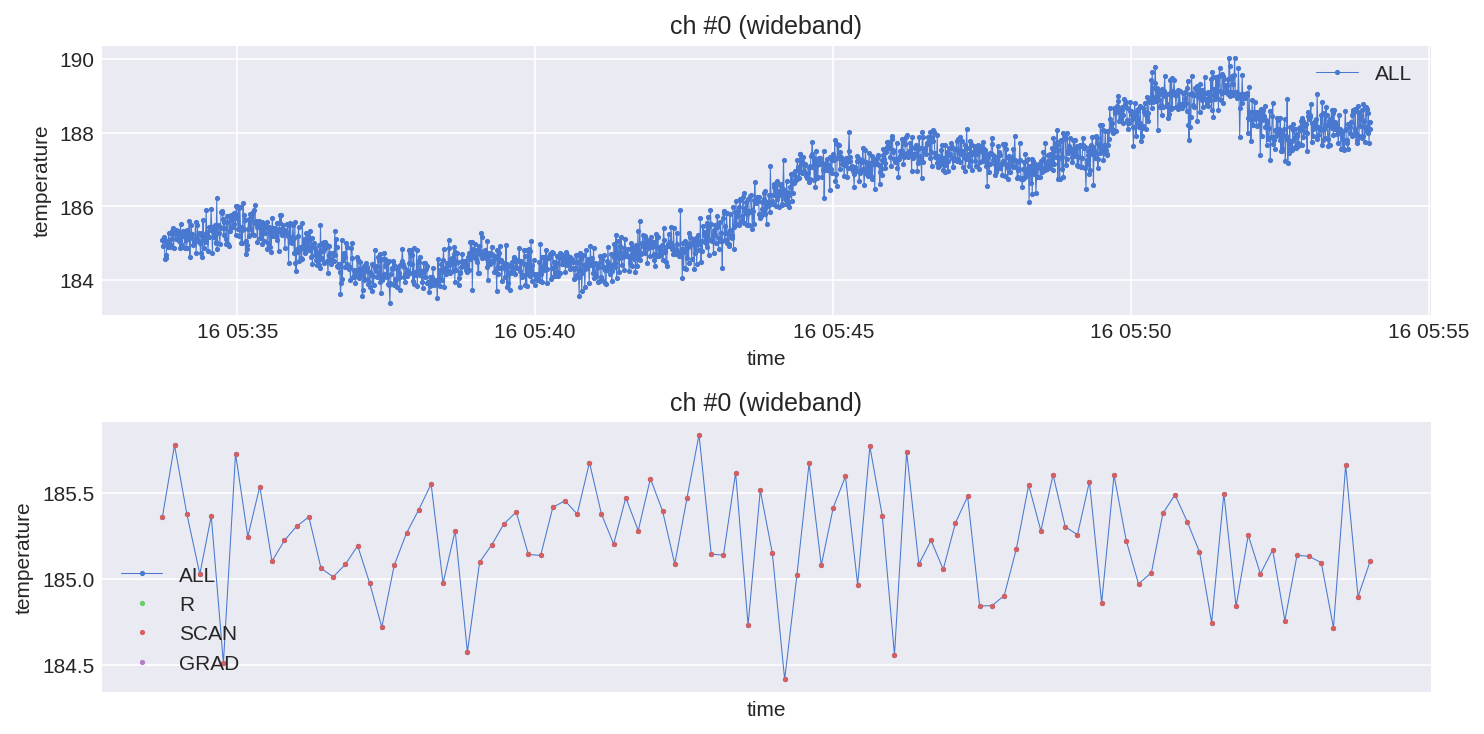

In [3]:
# plot time stream data
fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=dpi)

plot_params0 = {"marker": ".", "markersize": 3.0, "linewidth": 0.5}
plot_params1 = {"marker": ".", "markersize": 3.0, "linestyle": "None"}

dc.plot.plot_timestream(scanarray[::100], ch, ax=ax[0], **plot_params0) # plot every 100 points

dc.plot.plot_timestream(scanarray[2000:2100], ch, ax=ax[1], **plot_params0)
dc.plot.plot_timestream(scanarray[2000:2100], ch, scantypes=["R"], ax=ax[1], **plot_params1)
dc.plot.plot_timestream(scanarray[2000:2100], ch, scantypes=["SCAN"], ax=ax[1], **plot_params1)
dc.plot.plot_timestream(scanarray[2000:2100], ch, scantypes=["GRAD"], ax=ax[1], **plot_params1)

ax[0].grid(which="both")
ax[1].grid(which="both")

fig.tight_layout()
plt.show()

/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


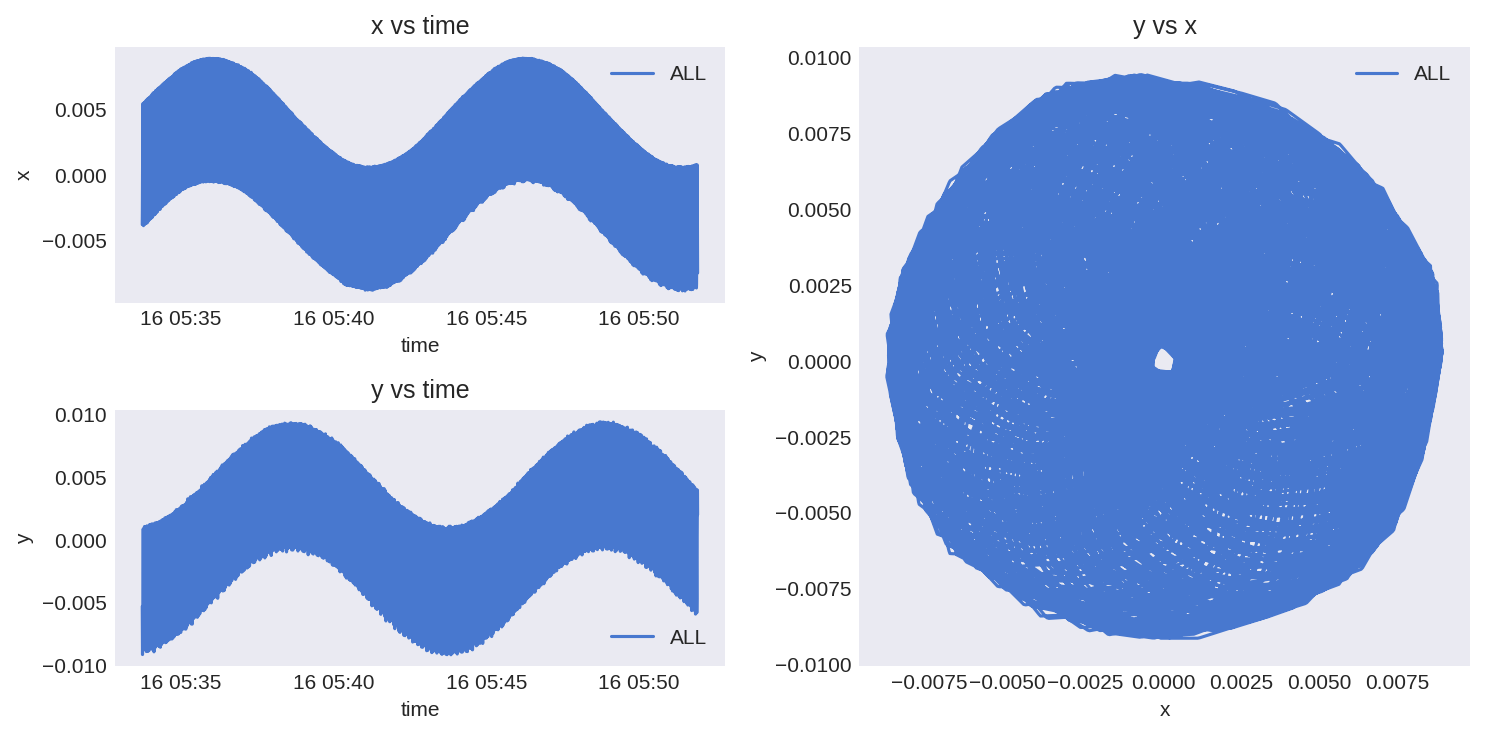

In [4]:
# plot antenna movements
fig = plt.figure(figsize=(10, 5), dpi=dpi)
gs = GridSpec(2, 2)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[1, 0], sharex=ax[0]))
ax.append(fig.add_subplot(gs[:, 1]))

dc.plot.plot_tcoords(scanarray[:-20000], ("time", "x"), ax=ax[0])
dc.plot.plot_tcoords(scanarray[:-20000], ("time", "y"), ax=ax[1])
dc.plot.plot_tcoords(scanarray[:-20000], ("x", "y"), ax=ax[2])

fig.tight_layout()
fig.show()

In [5]:
# interpolation
scanarray_interp = resample_with_equal_dt(scanarray)

# filter design
dt = np.unique(np.diff(scanarray_interp.time))[0] / np.timedelta64(1, "s")
fs = 1 / dt
fnyq = fs / 2
cutoff = 0.1
worN = 4096

numtaps_0 = 1001
hpf_0 = signal.firwin(numtaps=numtaps_0, cutoff=cutoff/fnyq, fs=fs/fnyq, pass_zero="highpass")

numtaps_1 = 5001
hpf_1 = signal.firwin(numtaps=numtaps_1, cutoff=cutoff/fnyq, fs=fs/fnyq, pass_zero="highpass")

numtaps_2 = 10001
hpf_2 = signal.firwin(numtaps=numtaps_2, cutoff=cutoff/fnyq, fs=fs/fnyq, pass_zero="highpass")

n_ana = 10
b_ana = signal.butter(N=n_ana, Wn=cutoff, btype="highpass", analog=True, output='sos')

n_dig = 10
b_dig = signal.butter(N=n_dig, Wn=cutoff, btype="highpass", fs=fs, output='sos')

plot_params = {"ls": "-", "marker": "o", "ms": 3.0}

#fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)
#plot_filter_response(
#    coefficients = [(hpf_0, 1), (hpf_1, 1), (hpf_2, 1), (b_ana, a_ana), (b_dig, a_dig)],
#    filtertypes = ["digital", "digital", "digital", "analog", "digital"],
#    worN=worN,
#    fs=fs,
#    **plot_params
#)
#ax.legend(["hpf_0", "hpf_1", "hpf_2", "butter (ana)", "butter (dig)"])

#fig.show()


In [6]:
# calculate group delay
#w, gd = signal.group_delay((hpf_2, 1), w=worN, fs=fs)
#n_delay = round(np.median(gd))
#print(n_delay)

#fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)

#ax.semilogx(w, gd, **plot_params)
#ax.set_xlabel("Frequency [Hz]")
#ax.set_ylabel("Group Delay [samples]")
#ax.grid(which="both")

#fig.show()

In [7]:
# interpolation and filtering
scanarray_interp = resample_with_equal_dt(scanarray)

scanarray_interp.kidtp[[16, 18, 44, 46]] = -1
scanarray_interp = scanarray_interp.where(scanarray_interp.kidtp == 1, drop=True)
scanarray_interp_sub = scanarray_interp[:, [30, 31, 32, 33, 34, 35]] # ch = 30-35 (for fast calculation)

t_rel = ((scanarray_interp.time - scanarray_interp.time[0]) / np.timedelta64(1, "s")).values # time offset
# x = detrend(scanarray_interp_sub, periodic_boundary=True)
x = detrend(scanarray_interp_sub, periodic_boundary=False, axis=0) # equivalent to scipy.signal.detrend

@dc.xarrayfunc
def my_sosfiltfilt(x, b, axis):
    return signal.sosfiltfilt(b, x, axis=axis)
y = my_sosfiltfilt(x, b_dig, axis=0)
# y = my_lfilter(x, b_ana, a_ana, axis=0)

/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


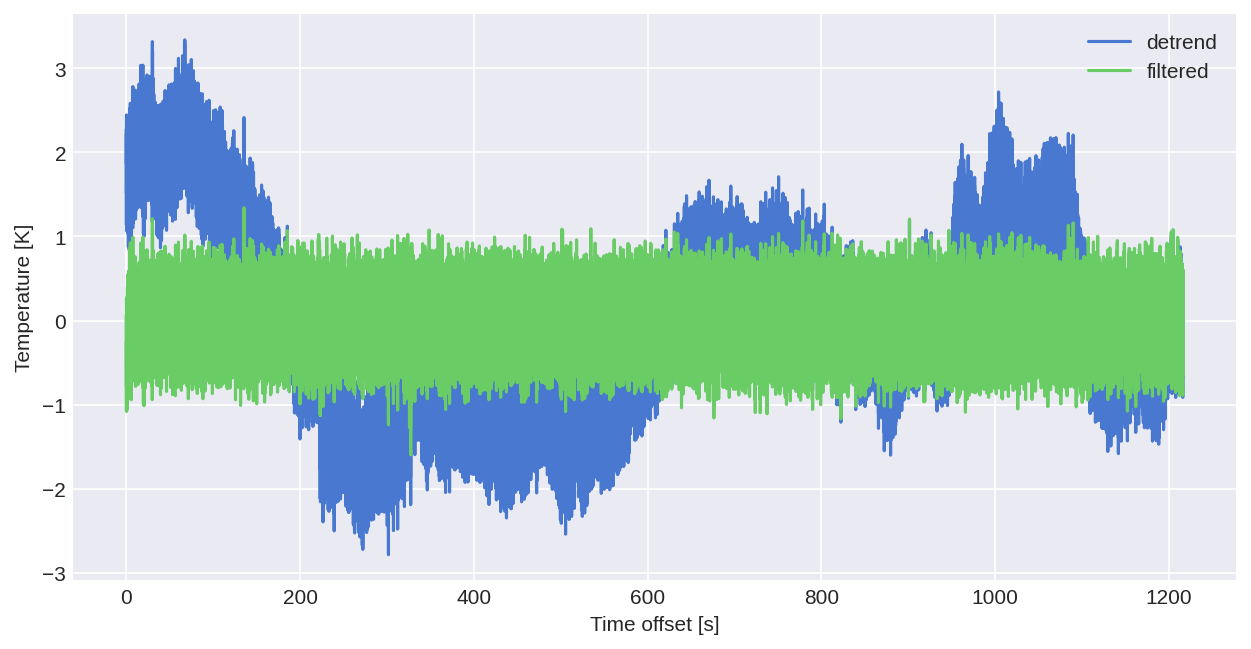

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=dpi)
n_delay=1
t_d = t_rel[:-n_delay]
x_d = x[:-n_delay]
y_d = y[n_delay:]

ax.plot(t_d, x_d[:, 1], label="detrend")
ax.plot(t_d, y_d[:, 1], label="filtered")
ax.set_xlabel("Time offset [s]")
ax.set_ylabel("Temperature [K]")
ax.legend()
ax.grid(which="both")

fig.show()

In [9]:
n_yd = -20000 # remove last 20000 samples (bad antenna movement)
n_xd = n_yd + n_delay

x_d_sub = x_d[:n_xd]
y_d_sub = y_d[:n_yd]

gx = params["imaging"]["gx"]
gy = params["imaging"]["gy"]

xmin = y_d_sub.x.min().values
xmax = y_d_sub.x.max().values
ymin = y_d_sub.y.min().values
ymax = y_d_sub.y.max().values

In [10]:
# make cube
cube_array = dc.tocube(y_d_sub, gx=gx, gy=gy, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
dc.io.savefits(cube_array[:, :, 0], cube_fits, dropdeg=True, overwrite=True)

# make continuum
weight = dc.ones_like(cube_array)
cont_array = makecontinuum(cube_array, weight=weight)
dc.io.savefits(cont_array, cont_fits, dropdeg=True, overwrite=True)

/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.792e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.172e-01 [aplpy.core]


/mnt/c/Users/takekoshi/Downloads/qlook/snippets/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


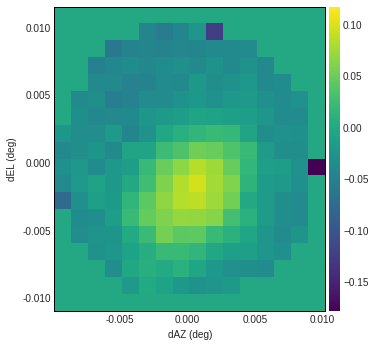

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = aplpy.FITSFigure(str(cont_fits), figure=fig, subplot=(1, 1, 1))

ax.show_colorscale(cmap="viridis", stretch="linear")
ax.add_colorbar(width=0.15)

fig.tight_layout()
fig.show()

In [12]:
# N = len(t_rel) # the number of samples

# freq = fft.fftfreq(N, d=1/fs) # frequency

# # f_x = fft.fft(x, axis=0) # original
# # f_xd = fft.fft(x_d, axis=0)
# # f_y = fft.fft(y, axis=0) # filtered
# f_x = fft.fft(x.values, axis=0) # original
# f_xd = fft.fft(x_d.values, axis=0)
# f_xnoise = fft.fft(x_noise, axis=0)
# f_y = fft.fft(y, axis=0) # filtered

# amp_x = np.abs(f_x / (N / 2)) # original
# amp_xd = np.abs(f_xd / (N / 2))
# amp_xnoise = np.abs(f_xnoise / (N / 2))
# amp_y = np.abs(f_y / (N / 2)) # filtered

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

# # ax.plot(freq[1:int(N / 2)], amp_x[1:int(N / 2), 1], label="original")
# # ax.plot(freq[1:int(N / 2)], amp_xd[1:int(N / 2), 1], label="detrended")
# ax.plot(freq[1:int(N / 2)], amp_xnoise[1:int(N / 2)], label="noise")
# ax.plot(freq[1:int(N / 2)], amp_y[1:int(N / 2)], label="filtered")
# # ax.plot(freq[1:int(N / 2)], amp_y[1:int(N / 2), 1], label="filtered")
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel("Amplitude")
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()

# fig.show()